# Interpolate SNODAS Infil to model grid
Here I'll interpolate the SNODAS infiltration netcdf to the model grid.  I'll start with just the single mean daily infiltration.  Which SEEMS way too high at the moment.

In [1]:
#imports
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet, FlowAccumulation
from gsflow.builder import ModflowBuilder
import pdb
import rasterio as rio
from rasterio.plot import show as rshow

### Read in the average netcdf raster data


In [2]:

##################################################
# Input path management
##################################################

# set our cell size in meters.  #I'll start out with 100m for now, but will likely refine
cellsize=100
method='nearest'

#model name
model_name = "Rattlesnakecreek_%3im"%cellsize+method

#project path
project_path = "/Users/payton.gardner/proj/active/RattlensnakeModel"

#toplevel output path
model_path = os.path.join(project_path,"models",model_name)

#derived gis output path
gis_derived_path = os.path.join(project_path,model_path,"gis_deriv")

#gis data path
gis_data_path = os.path.join(project_path,'data','gis')

# precip data path
precip_file = "daily_mean_infiltration.nc"
precip_data_path = os.path.join(project_path,'data','Precip',precip_file)

#grid file path
gridname = 'grid.bin'
mg_file = os.path.join(model_path, gridname)

#mf output path
#mf_path = os.path.join(model_path,'modflow')
mf_path = model_path



In [3]:

#######################################################
#Load Data
#######################################################
# load model grid
modelgrid = GenerateFishnet.load_from_file(mg_file)

# load raster data with flopy
robj = flopy.utils.Raster.load(precip_data_path)

    

In [4]:
# resample precip data to grid
precip_data = robj.resample_to_grid(
    modelgrid, 
    robj.bands[0], 
    method=method, 
    multithread=False, 
    thread_pool=12
)

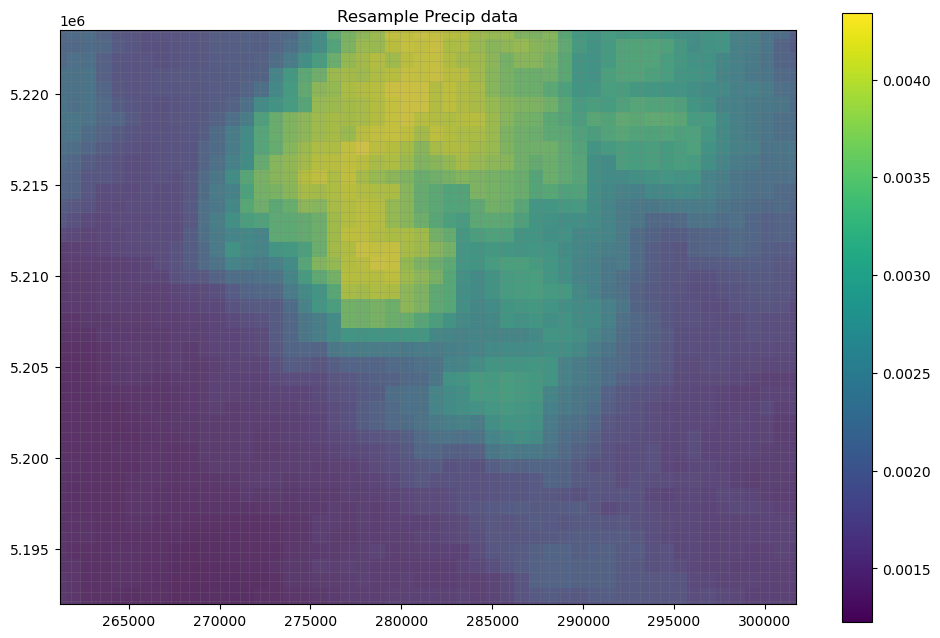

In [5]:
# make a plot of the data
# plot the resampled DEM with the modelgrid overlain
fig2 = plt.figure(figsize=(10,9))
ax2 = fig2.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax2)
ax2 = pmv.plot_array(
    precip_data, masked_values=robj.nodatavals, vmin=precip_data.min(), vmax=precip_data.max()
)
lc = pmv.plot_grid(color="grey", lw=0.3)
plt.title("Resample Precip data")
plt.colorbar(ax2, shrink=0.7)
plt.tight_layout()
plt.show()

In [6]:
modelgrid.shape

(1, 316, 405)

In [7]:
precip_data.shape

(316, 405)

In [10]:
# Save the resampled data
precipresampled_file = 'precipresampled.txt'
precipresampled_rfile = 'precipresampled.tif'
precipresampled_file = os.path.join(gis_derived_path,precipresampled_file)
precipresampled_rfile = os.path.join(gis_derived_path,precipresampled_rfile)

#######################################################
#Save Data
#######################################################

np.savetxt(precipresampled_file, precip_data, delimiter="  ")

#output a tif file for post processing with SAGA.  
flopy.export.utils.export_array(modelgrid,precipresampled_rfile,\
                                precip_data,fieldname='Infiltration')